In [1]:
import pandas as pd
import numpy as np

import glob

from sklearn.cluster import KMeans

from fastai.tabular import *

import datetime

from math import radians, cos, sin, asin, sqrt, pi

from geographiclib.geodesic import Geodesic

import matplotlib.pyplot as plt 

from IPython.display import clear_output

import requests

In [2]:
density_kmeans = None
speed_kmeans = None

In [3]:
def load_kmeans():
    with open('../models/traffic-cluster-density-20-kmeans.pkl', 'rb') as pkl:
        global density_kmeans
        density_kmeans = pickle.load(pkl)
    with open('../models/traffic-cluster-speed-20-kmeans.pkl', 'rb') as pkl:
        global speed_kmeans
        speed_kmeans = pickle.load(pkl)

In [4]:
valid_df = pd.concat([pd.read_csv(f, encoding='latin1') for f in glob.glob('../data/validation/*.csv')])

In [5]:
valid_df = valid_df.rename(columns={ 
    'rawlat': 'origin_lat', 'rawlng': 'origin_lng', 'pingtimestamp': 'origin_timestamp',
    'rawlat2': 'dest_lat', 'rawlng2': 'dest_lng', 'pingtimestamp2': 'dest_timestamp',
})

In [6]:
valid_df_duration = valid_df.dest_timestamp - valid_df.origin_timestamp

In [7]:
load_kmeans()

/home/jjkoh/anaconda3/envs/ml-3.7/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KMeans from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
dicts = valid_df.to_dict('records')

In [9]:
def proc_datetime(row):
    dt = datetime.datetime.fromtimestamp(row['origin_timestamp'] - 28800)
    row['day_of_week'] = int(dt.weekday())
    row['hour_of_day'] = int(dt.hour)
    return row

In [10]:
valid_df['day_of_week'] = 0
valid_df['hour_of_day'] = 0

In [11]:
valid_df = valid_df.apply(proc_datetime, axis=1)

In [12]:
valid_df.head()

,origin_lat,origin_lng,origin_timestamp,dest_lat,dest_lng,dest_timestamp,day_of_week,hour_of_day
0,1.340839,103.848598,1.554850e+09,1.344806,103.983101,1.554851e+09,1.0,22.0
1,1.375949,103.854017,1.555030e+09,1.319886,103.881859,1.555031e+09,4.0,0.0
2,1.272912,103.843105,1.555585e+09,1.344893,103.716199,1.555587e+09,3.0,11.0
3,1.318947,103.903400,1.555055e+09,1.360454,103.937541,1.555056e+09,4.0,7.0
4,1.302866,103.893107,1.555326e+09,1.347796,103.957698,1.555327e+09,0.0,11.0


In [13]:
valid_df = valid_df[['origin_lat', 'origin_lng', 'dest_lat', 'dest_lng', 'day_of_week', 'hour_of_day']]

In [14]:
dicts = valid_df.to_dict('records')

In [15]:
dicts[0]

{'origin_lat': 1.3408386763014144,
 'origin_lng': 103.84859766018715,
 'dest_lat': 1.3448060250658491,
 'dest_lng': 103.9831013487792,
 'day_of_week': 1.0,
 'hour_of_day': 22.0}

In [16]:
res = requests.post(
    'http://localhost:8080/grab/eta/stackensemble',
    json=dicts[0]
)

In [17]:
res.json()['eta']

968

In [18]:
res = {'actual': [None]*valid_df.shape[0], 'predicted': [None]*valid_df.shape[0]}

In [19]:
def for_requests():
    for i, row in enumerate(dicts):
        print(i, len(dicts))
        clear_output(wait=True)
        pred = requests.post(
            'http://localhost:8080/grab/eta/stackensemble',
            json=row
        )
        actual = valid_df_duration.values[i]
        res['actual'][i] = actual
        res['predicted'][i] = pred.json()['eta']
        
for_requests()

27999 28000


In [81]:
res_df = pd.DataFrame.from_dict(res)

In [82]:
res_df.head()

,actual,predicted
0,1019.0,968.0
1,979.0,1040.0
2,1629.0,1269.0
3,1116.0,1148.0
4,1075.0,1026.0


In [83]:
((res_df.predicted - res_df.actual) ** 2).mean() ** .5

276.9959014809234

In [84]:
temp_df = res_df[res_df.actual < 2000]
((temp_df.predicted - temp_df.actual) ** 2).mean() ** .5

226.77975534079852

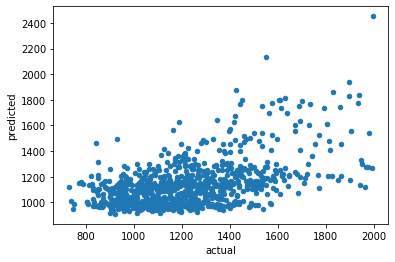

In [85]:
temp_df.plot.scatter(x='actual', y='predicted')

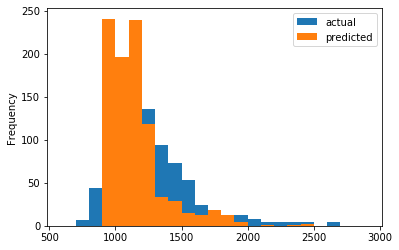

In [86]:
res_df.plot.hist(bins=np.arange(600, 3000, 100))

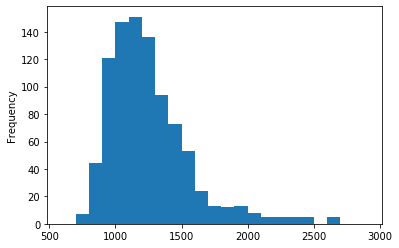

In [87]:
res_df.actual.plot.hist(bins=np.arange(600, 3000, 100))

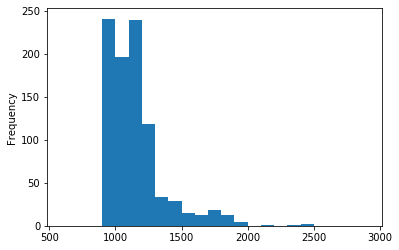

In [88]:
res_df.predicted.plot.hist(bins=np.arange(600, 3000, 100))